# Get Point of Interest Data

In [ ]:
!pip install geopandas

In [1]:
# If you see the error `ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed` this can be ignored.
import os
import os.path
from urllib.parse import urlparse
import datetime as dt
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import shapely

## Configure and download data

Set the `WKT_FILE` to the file of you area of interest in WKT format.

Download Point of Interest (POI) data int `.shp` file formar, prepared by Geofabrik:  http://download.geofabrik.de/europe/germany/hamburg.html (also see the [different locations](http://download.geofabrik.de/index.html) available).

Also see the documentioatn of Geofabrik for the included files and their POI categories [here](http://download.geofabrik.de/osm-data-in-gis-formats-free.pdf).

The catgories (`fclass`) can be also used to narrow down your POI list in the `FILTER_CLASSES` variable.

In [2]:
# Set to URL of .shp file for you region
SHP_FILE_URL = 'http://download.geofabrik.de/europe/germany/hamburg-latest-free.shp.zip'

# Optional filter of fclasses, see top categories in previoius cell
# or the Geofabrik documentation for all available POI categories.
FILTER_CLASSES = []

# read in shape from WKT file  with our AOI
WKT_FILE = 'Hamburg_HAW_Area.wkt'


# no need to change
SHP_FILE   = Path(urlparse(SHP_FILE_URL).path).name
SHP_FOLDER = Path(urlparse(SHP_FILE_URL).path).stem

In [3]:
!wget -nc $SHP_FILE_URL

File ‘hamburg-latest-free.shp.zip’ already there; not retrieving.



In [4]:
!mkdir -p $SHP_FOLDER
!unzip -n $SHP_FILE -d $SHP_FOLDER

Archive:  hamburg-latest-free.shp.zip


## Filter data down to our Area of Interest (AOI)

In [5]:
with open(WKT_FILE) as f:
    wkt = f.read()
    
shape = shapely.wkt.loads(wkt)

In [6]:
# Path to Geofabrik shp files folder
GEOFDIR = Path(f'{SHP_FOLDER}/')

In [7]:
# read in all POIs from file
gdf = geopandas.read_file(GEOFDIR / 'gis_osm_pois_free_1.shp')

In [8]:
# select only those inside our AOI
aoi_gdf = gdf[gdf.within(shape)].reset_index(drop=True)

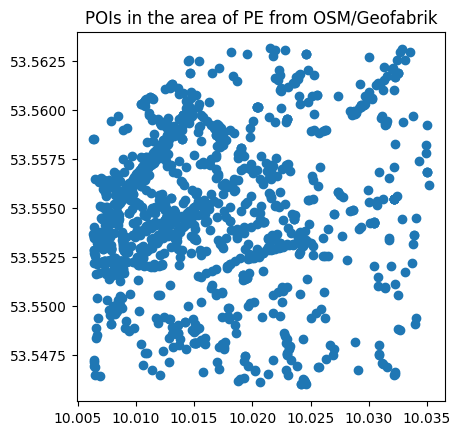

In [9]:
aoi_gdf.plot()
plt.title("POIs in the area of PE from OSM/Geofabrik")
plt.show()

In [10]:
len(aoi_gdf) # amount of POIs in area 

1287

In [11]:
# top 20 categories available in PE
aoi_gdf['fclass'].value_counts().head(20)

memorial               205
bench                  110
waste_basket           103
restaurant             101
vending_any             80
camera_surveillance     79
vending_parking         50
fast_food               43
hotel                   41
cafe                    40
telephone               28
bakery                  28
post_box                23
atm                     20
tourist_info            19
clothes                 18
bar                     18
hairdresser             17
pub                     15
kiosk                   14
Name: fclass, dtype: int64

In [12]:
# overwrite dataframe with filtered view
# if you want to have all data back again, you need to rerun the cell's above 
if FILTER_CLASSES:
    aoi_gdf = aoi_gdf[aoi_gdf['fclass'].isin(FILTER_CLASSES)]

In [13]:
# Save to geojson file we can use in MARS
res = Path("./GeoVectorBlueprint/Resources")
res.mkdir(parents=True, exist_ok=True)

# if the file already exists make a backup
if (res / 'pois.geojson').is_file():
    now = dt.datetime.now()
    os.rename(res / 'pois.geojson', res / f'bkp_pois_{now.strftime("%Y%m%d_%H%M%S")}.geojson')

aoi_gdf.to_file(res / "pois.geojson", driver="GeoJSON")